# Code for gaussian benchmark baselines

## 1. Imports

In [1]:
from eot_benchmark.gaussian_mixture_benchmark import (
    get_guassian_mixture_benchmark_sampler,
    get_guassian_mixture_benchmark_ground_truth_sampler, 
)

from eot_benchmark.metrics import (
    compute_BW_UVP_by_gt_samples, calculate_gm_mmd
)

In [2]:
import math
import gc
import wandb
import numpy as np

from matplotlib import pyplot as plt
import matplotlib

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

In [3]:
gc.collect(); torch.cuda.empty_cache()

## 2. Config

In [4]:
DIM = 2
EPS = 1
assert DIM > 1

L1 = 1e-10
GPU_DEVICE = 7
EPSILON = EPS
BATCH_SIZE = 32

SEED = 42
MAX_STEPS = 501
METRICS_INTERVAL = 500
CONTINUE = -1

# identity, independet, linear
BASELINE_TYPE = "identity"

In [5]:
EXP_NAME = f'Gaussians_{BASELINE_TYPE}_baseline_EPSILON_{EPSILON}_DIM_{DIM}'

config = dict(
    DIM=DIM,
    EPSILON=EPSILON,
    SEED=SEED,
    MAX_STEPS=MAX_STEPS,
)

In [6]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

## 3. Initialize Benchmark

In [7]:
torch.manual_seed(SEED); np.random.seed(SEED);
X_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=DIM, eps=EPS,
                                           batch_size=BATCH_SIZE, device="cuda", download=True)
Y_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=DIM, eps=EPS,
                                          batch_size=BATCH_SIZE, device="cuda", download=False)

ground_truth_plan_sampler = get_guassian_mixture_benchmark_ground_truth_sampler(dim=DIM, eps=EPS,
                                                                                batch_size=BATCH_SIZE, 
                                                                                device="cuda",
                                                                                download=False)

Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /root/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████| 199k/199k [00:00<00:00, 3.04MB/s]


In [8]:
pca = PCA(n_components=2)

samples = X_sampler.sample(10000)
samples = samples.cpu()

target_samples = Y_sampler.sample(10000)
target_samples = target_samples.cpu()

# pca.fit(torch.cat((samples, target_samples)))
pca.fit(target_samples)

PCA(n_components=2)

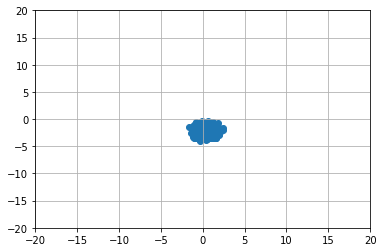

In [9]:
samples_pca = pca.transform(samples)

plt.scatter(samples_pca[:, 0], samples_pca[:, 1])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid()

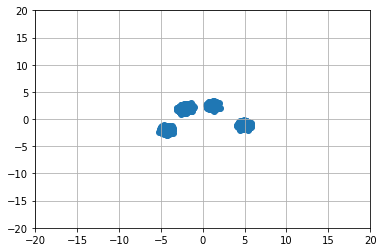

In [10]:
target_samples_pca = pca.transform(target_samples)
plt.scatter(target_samples_pca[:, 0], target_samples_pca[:, 1])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid()

## 4. Model initialization

In [11]:
class IdentityBaseline(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x
    

class IndependentBaseline(nn.Module):
    def __init__(self, target_sampler):
        super().__init__()
        self.target_sampler = target_sampler

    def forward(self, x):
        return self.target_sampler.sample(x.shape[0]).to(x.device)


if BASELINE_TYPE == "identity":
    model = IdentityBaseline()
elif BASELINE_TYPE == "independet":
    model = IndependentBaseline(Y_sampler)

### For plotting

In [12]:
from PIL import Image

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )


def pca_plot(x_0_gt, x_1_gt, x_1_pred, n_plot, step):
    fig,axes = plt.subplots(1, 3,figsize=(12,4),squeeze=True,sharex=True,sharey=True)
    pca = PCA(n_components=2).fit(x_1_gt)
    
    x_0_gt_pca = pca.transform(x_0_gt[:n_plot])
    x_1_gt_pca = pca.transform(x_1_gt[:n_plot])
    x_1_pred_pca = pca.transform(x_1_pred[:n_plot])
    
    axes[0].scatter(x_0_gt_pca[:,0], x_0_gt_pca[:,1], c="g", edgecolor = 'black',
                    label = r'$x\sim P_0(x)$', s =30)
    axes[1].scatter(x_1_gt_pca[:,0], x_1_gt_pca[:,1], c="orange", edgecolor = 'black',
                    label = r'$x\sim P_1(x)$', s =30)
    axes[2].scatter(x_1_pred_pca[:,0], x_1_pred_pca[:,1], c="yellow", edgecolor = 'black',
                    label = r'$x\sim T(x)$', s =30)
    
    for i in range(3):
        axes[i].grid()
        axes[i].set_xlim([-10, 10])
        axes[i].set_ylim([-10, 10])
        axes[i].legend()
    
    fig.tight_layout(pad=0.5)
    wandb.log({f'Plot PCA samples' : [wandb.Image(fig2img(fig))]}, step=step)
    
def plot_mapping(independent_mapping, true_mapping, predicted_mapping, target_data, n_plot, step):
    s=30
    linewidth=0.2
    map_alpha=1
    data_alpha=1
    figsize=(5, 5)
    dpi=None
    data_color='red'
    mapped_data_color='blue'
    map_color='green'
    map_label=None
    data_label=None
    mapped_data_label=None
    
    dim = target_data.shape[-1]
    pca = PCA(n_components=2).fit(target_data)
    
    independent_mapping_pca = np.concatenate((        
        pca.transform(independent_mapping[:n_plot, :dim]),
        pca.transform(independent_mapping[:n_plot, dim:]),
        ), axis=-1)
 
    true_mapping_pca = np.concatenate((
        pca.transform(true_mapping[:n_plot, :dim]),
        pca.transform(true_mapping[:n_plot, dim:]),
    ), axis=-1)
    
    predicted_mapping_pca = np.concatenate((
        pca.transform(predicted_mapping[:n_plot, :dim]),
        pca.transform(predicted_mapping[:n_plot, dim:]),
    ), axis=-1)
    
    target_data_pca = pca.transform(target_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4),squeeze=True,sharex=True,sharey=True)
    titles = ["independent", "true", "predicted"]
    for i, mapping in enumerate([independent_mapping_pca, true_mapping_pca, predicted_mapping_pca]):
        inp = mapping[:, :2]
        out = mapping[:, 2:]

        lines = np.concatenate([inp, out], axis=-1).reshape(-1, 2, 2)
        lc = matplotlib.collections.LineCollection(
            lines, color=map_color, linewidths=linewidth, alpha=map_alpha, label=map_label)
        axes[i].add_collection(lc)

        axes[i].scatter(
            inp[:, 0], inp[:, 1], s=s, label=data_label,
            alpha=data_alpha, zorder=2, color=data_color)
        axes[i].scatter(
            out[:, 0], out[:, 1], s=s, label=mapped_data_label,
            alpha=data_alpha, zorder=2, color=mapped_data_color)

        axes[i].scatter(target_data_pca[:1000,0], target_data_pca[:1000,1], c="orange", edgecolor = 'black',
                    label = r'$x\sim P_1(x)$', s =10)
        axes[i].grid()
        axes[i].set_title(titles[i])
    
    wandb.log({f'Plot PCA plan samples' : [wandb.Image(fig2img(fig))]}, step=step)

## 5. Training

In [13]:
wandb.init(name=EXP_NAME, config=config, project='SchrodingerBridge')

wandb: Currently logged in as: schrodinger_bridge (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.15.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


100%|██████████| 501/501 [01:02<00:00,  8.05it/s]


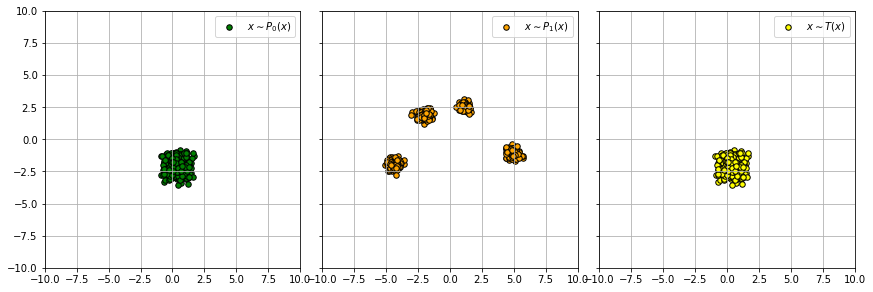

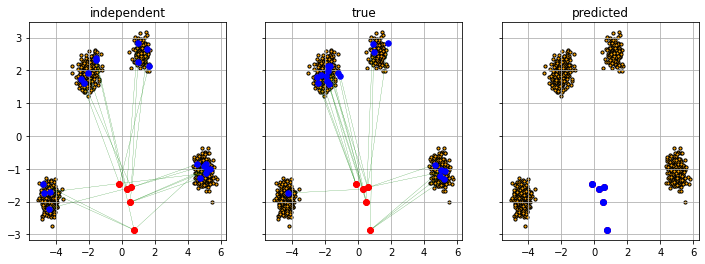

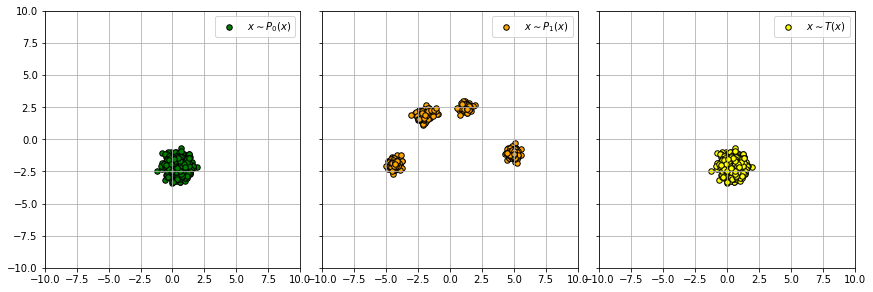

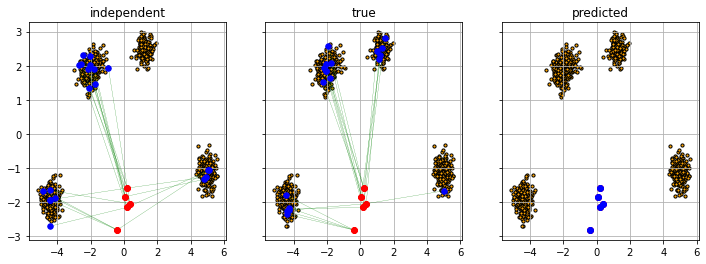

In [14]:
torch.manual_seed(SEED); np.random.seed(SEED)

for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    model.train()
    
    if step % METRICS_INTERVAL == 0:
        model.eval()
        # metrics
        with torch.no_grad():
            # calcualte bw-uvp
            X = X_sampler.sample(100000).cuda()
            Y = Y_sampler.sample(100000).cuda()
            
            XN = model(X)
            X0_XN = torch.cat((X, XN), dim=1)

            X0_gt, XN_gt = ground_truth_plan_sampler.sample(100000)
            X0_XN_gt = torch.cat((X0_gt, XN_gt), dim=1)
            
            bw_uvp_target = compute_BW_UVP_by_gt_samples(XN.cpu().numpy(), Y.cpu().numpy())
            bw_uvp_plan = compute_BW_UVP_by_gt_samples(X0_XN.cpu().numpy(), X0_XN_gt.cpu().numpy())
            
            pca_plot(X.detach().cpu().numpy(), Y.detach().cpu().numpy(),
                     XN.detach().cpu().numpy(), n_plot=500, step=step)
            
            # plot map
            X_repeated = X0_gt[:5].repeat(20, 1).cuda()
            Y_true_mapped = ground_truth_plan_sampler.conditional_plan.sample(X_repeated).cuda()
            
            true_plan = torch.cat((X_repeated, Y_true_mapped), dim=-1)
            independent_plan = torch.cat((X_repeated, Y[:100]), dim=-1)
            predicted_plan = torch.cat((X_repeated, model(X_repeated)), dim=-1)
            
            plot_mapping(independent_plan.detach().cpu().numpy(), true_plan.detach().cpu().numpy(),
                     predicted_plan.detach().cpu().numpy(), Y.detach().cpu().numpy(),
                         n_plot=20, step=step)
            
            # calculate mmd
            X = X_sampler.sample(10000).cuda()
            Y = Y_sampler.sample(10000).cuda()
            
            XN = model(X)
            X0_XN = torch.cat((X, XN), dim=1)

            X0_gt, XN_gt = ground_truth_plan_sampler.sample(10000)
            X0_gt, XN_gt = X0_gt.cuda(), XN_gt.cuda()
            X0_XN_gt = torch.cat((X0_gt, XN_gt), dim=1)
            

            mmd_plan = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                        normalization_type="indep_plan_rbf_kernel")
            mmd_plan_dim_normalized = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                                       normalization_type="indep_plan_rbf_kernel_dim_norm")
            mmd_plan_distance_kernel = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                                        normalization_type="indep_plan_rbf_distance_kernel")
            
            
            mmd_plan_identity = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                        normalization_type="identity_plan_rbf_kernel")
            mmd_plan_identity_dim_normalized = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                                       normalization_type="indentity_plan_rbf_kernel_norm")
            mmd_plan_identity_distance_kernel = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                                        normalization_type="identity_plan_distance_kernel")
            

            mmd_target = calculate_gm_mmd(XN, Y, dim=DIM, eps=EPS, normalization_type="identity_rbf_kernel")
            mmd_target_dim_normalized = calculate_gm_mmd(XN, Y, dim=DIM, eps=EPS,
                                                         normalization_type="indentity_rbf_kernel_norm")
            mmd_target_distance_kernel = calculate_gm_mmd(XN, Y, dim=DIM, eps=EPS, 
                                                          normalization_type="identity_distance_kernel")

            wandb.log({f'BW-UVP_target' : bw_uvp_target}, step=step)
            wandb.log({f'BW-UVP_plan' : bw_uvp_plan}, step=step)

            wandb.log({f'MMD_plan' : mmd_plan}, step=step)
            wandb.log({f'MMD_plan_dim_normalized' : mmd_plan_dim_normalized}, step=step)
            wandb.log({f'MMD_plan_distance_kernel' : mmd_plan_distance_kernel}, step=step)
            
            wandb.log({f'MMD_plan_identity' : mmd_plan_identity}, step=step)
            wandb.log({f'MMD_plan_identity_dim_normalized' : mmd_plan_identity_dim_normalized}, step=step)
            wandb.log({f'MMD_plan_identity_distance_kernel' : mmd_plan_identity_distance_kernel}, step=step)

            wandb.log({f'MMD_target' : mmd_target}, step=step)
            wandb.log({f'MMD_target_dim_normalized' : mmd_target_dim_normalized}, step=step)
            wandb.log({f'MMD_target_distance_kernel' : mmd_target_distance_kernel}, step=step)

    gc.collect(); torch.cuda.empty_cache()